In [1]:
%config Completer.use_jedi = False

from IPython import display
import logging
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time
from tensorflow.keras import layers, losses
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd
from sklearn.mixture import GaussianMixture

seed = 1
np.random.seed(1)
tf.random.set_seed(1)

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

In [3]:
# configs
latent_dim = 4096
batch_size = 32
channel = 2

# logger
logging.basicConfig(level = logging.DEBUG)

In [4]:
def preprocess_images(images,channel):
    #images=images[:,:,:,channel] # channel
    #images = images.reshape((images.shape[0], 32, 32,3, 1)) / 255.
    return images/255.
train_images = preprocess_images(train_images,channel)
test_images = preprocess_images(test_images,channel)

In [5]:
train_images.shape

(50000, 32, 32, 3)

In [6]:
class CAE(tf.keras.Model):
    """Convolutional variational autoencoder."""

    def __init__(self, latent_dim):
        super(CAE, self).__init__()
        self.latent_dim = latent_dim
        self.logger = logging.getLogger('CAE')
        self.encoder = tf.keras.Sequential(name='encoder',layers=\
            [
                tf.keras.layers.InputLayer(input_shape=(32, 32, 3)),
                tf.keras.layers.Conv2D(
                    filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
                tf.keras.layers.Conv2D(
                    filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
                tf.keras.layers.Flatten(),
                # No activation
                tf.keras.layers.Dense(latent_dim),
            ]
        )

        self.decoder = tf.keras.Sequential(name='decoder',layers=\
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                tf.keras.layers.Dense(units=8 * 8 * 32, activation=tf.nn.relu),
                tf.keras.layers.Reshape(target_shape=(8, 8, 32)),
                tf.keras.layers.Conv2DTranspose(
                    filters=64, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                tf.keras.layers.Conv2DTranspose(
                    filters=32, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                # No activation
                tf.keras.layers.Conv2DTranspose(
                    filters=3, kernel_size=3, strides=1, padding='same'),
            ]
        )

        self.encoder.summary()
        self.decoder.summary()
        
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


cae = CAE(latent_dim)
cae.compile(optimizer='adam', loss=losses.MeanSquaredError())

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2048)              8390656   
______________________________

In [7]:
cae.fit(x=train_images,y=train_images,validation_data=(test_images,test_images),epochs=10,\
        shuffle=True,batch_size=batch_size)

Epoch 1/10
1563/1563 [==============================] - 235s 149ms/step - loss: 0.0205 - val_loss: 0.0043
Epoch 2/10
1563/1563 [==============================] - 238s 153ms/step - loss: 0.0041 - val_loss: 0.0031
Epoch 3/10
1563/1563 [==============================] - 241s 154ms/step - loss: 0.0030 - val_loss: 0.0026
Epoch 4/10
1563/1563 [==============================] - 230s 147ms/step - loss: 0.0026 - val_loss: 0.0036
Epoch 5/10
1563/1563 [==============================] - 553s 354ms/step - loss: 0.0023 - val_loss: 0.0030
Epoch 6/10
1563/1563 [==============================] - 245s 157ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 7/10
1563/1563 [==============================] - 243s 155ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 8/10
1563/1563 [==============================] - 240s 153ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 9/10
1563/1563 [==============================] - 231s 148ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 10/10
1563/1563 [=======================

In [8]:
z = cae.encoder(test_images).numpy()
decoded_imgs = cae.decoder(z).numpy()

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmr10' (cmr10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 0.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmmi10' (cmmi10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXS

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial' (Arial.ttf) normal normal 400 normal>) = 6.413636363636363
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Wingdings 3' (Wingdings 3.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Ugaritic' (NotoSansUgaritic-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Trebuchet MS' (Trebuchet MS Bold Italic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Inscriptional Parthian' (NotoSansInscriptionalParthian-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kohinoor Telugu' (KohinoorTelugu.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Khmer MN' (Khm

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Avestan' (NotoSansAvestan-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial Unicode MS' (Arial Unicode.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Mandaic' (NotoSansMandaic-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Sundanese' (NotoSansSundanese-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.Aqua Kana' (AquaKana.ttc) normal normal 300 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Telugu Sangam MN' (Telugu Sangam MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Nadeem' (Nadeem.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Papyrus' (Papyrus.ttc) normal normal 400 condensed>)

DEBUG:matplotlib.font_manager:findfont: score(<Font 'PT Serif Caption' (PTSerifCaption.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsUp' (STIXIntUpReg.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Chalkboard SE' (ChalkboardSE.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Verdana' (Verdana Italic.ttf) italic normal 400 normal>) = 4.6863636363636365
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Trebuchet MS' (Trebuchet MS Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Regular.otf) normal normal 600 condensed>) = 10.44
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bangla MN' (Bangla MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Skia' (Skia.ttf) normal normal 5 normal>) = 10.4

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Meetei Mayek' (NotoSansMeeteiMayek-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymBol.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bodoni 72 Smallcaps' (Bodoni 72 Smallcaps Book.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans GB' (Hiragino Sans GB.ttc) normal normal 300 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Rockwell' (Rockwell.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Thonburi' (Thonburi.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Gothic' (NotoSansGothic-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Herculanum' (Herculanum.ttf) normal no

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tamil MN' (Tamil MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Mono' (SFNSMono.ttf) normal normal 300 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Cypriot' (NotoSansCypriot-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'New Peninim MT' (NewPeninimMT.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.Arabic UI Display' (ArabicUIDisplay.ttc) normal normal 900 normal>) = 10.525
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Old South Arabian' (NotoSansOldSouthArabian-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Telugu MN' (Telugu MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'System Font' (SFNSItalic.ttf) italic normal 400 normal>)

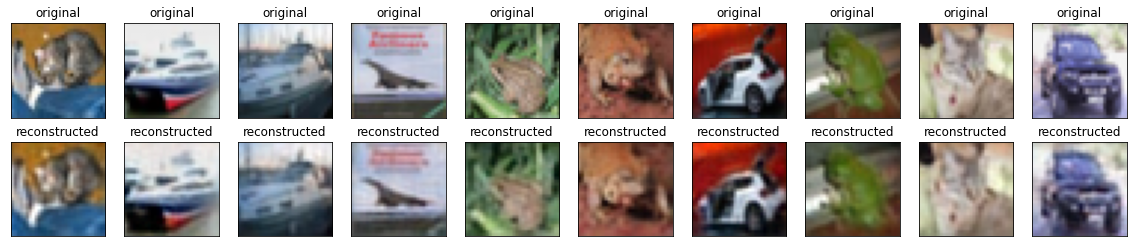

In [9]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_images[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [10]:
# def create_Gaussian_Mixture_Model(samples_tensor,k_list=[1]):
#     logger = logging.getLogger('create_Gaussian_Mixture_Model')
    
#     samples_np = samples_tensor.numpy()
#     min_aic,gm_min_aic,min_K = None,None,None
#     for k in k_list:
#         gm = GaussianMixture(n_components=k,covariance_type='diag').fit(samples_np)
#         gm_means = gm.means_
#         gm_cov = gm.covariances_
#         at_k_msg = f'At K = {k}'
#         logger.debug(f'{at_k_msg} - GM means = {gm_means}')
#         logger.debug(f'{at_k_msg} - GM cov = {gm_cov}')
#         aic = gm.aic(samples_np)
#         logger.debug(f'{at_k_msg} - GM AIC = {aic}')
#         logger.debug(f'{at_k_msg} - GM Weight {gm.weights_}')
#         if min_aic is None:
#             min_aic,gm_min_aic,min_K = aic,gm,k
#         elif aic < min_aic:
#             min_aic,gm_min_aic,min_K = aic,gm,k
#         logger.debug('------------------------------------')
#     logger.info (f'GM min AIC K = {min_K}')
#     # create tensorflow gm
#     dist_list = []
#     for i in range(len(gm_min_aic.means_)):
#         means_ = tf.convert_to_tensor(gm_min_aic.means_[i],dtype=tf.float64)
#         vars_ = tf.convert_to_tensor(gm_min_aic.covariances_[i],tf.float64)
#         mvn_diag = tfp.distributions.MultivariateNormalDiag(loc=means_,scale_diag=vars_)
#         dist_list.append(mvn_diag)
#     tf_gm = tfp.distributions.Mixture(cat=tfp.distributions.Categorical(probs=gm_min_aic.weights_)\
#                                       ,components=dist_list)
#     return tf_gm

In [11]:
def calc_z_likelihood(z,raxis = 0):
    
    n = len(z)
    n_train = int(0.8*n)
    z_train = z[:n_train]
    z_test = z[n_train:]
    logger = logging.getLogger('calc_z_likelihood')
    min_aic = None
    gm_fit_min_aic = None
    for k in range(1,8):

        gm_fit = GaussianMixture(n_components=k,covariance_type='diag').fit(z_train)
        aic_ = gm_fit.aic(z_test)
        logger.info(f'Built GM model with k = {k} and test aic = {aic_}')
        if min_aic is None:
            min_aic = aic_
            gm_fit_min_aic = gm_fit
        elif aic_ < min_aic:
            min_aic = min(aic_,min_aic)
            gm_fit_min_aic = gm_fit
    logger.info(f'best gm model with k = {len(gm_fit_min_aic.means_)} and test aic = {min_aic}')
    g_fit = GaussianMixture(n_components=1,covariance_type='diag').fit(z_train) # gaussian
    
    logp_dict = dict()
    logp_dict['GM_diag'] = np.nansum(gm_fit.score_samples(z_test))
    logp_dict['Gaus_diag'] = np.nansum(g_fit.score_samples(z_test))
    
    """
    
    sample_mean = tf.reduce_max(input_tensor=z_train,axis=raxis)
    sample_cov = tfp.stats.covariance(x=z_train)

    
    sample_var = tf.linalg.diag_part(input=sample_cov)+0.1

    mvn_diag = tfp.distributions.MultivariateNormalDiag(loc=sample_mean,scale_diag=sample_var)
    
    logger.debug(f'Gaus Diag sample mean = {sample_mean}')
    logger.debug(f'Gaus Diag sample cov = {sample_cov}')
    
    #mvn_tri = tfp.distributions.MultivariateNormalTriL(loc=sample_mean,scale_tril=L)
    log_p_diag = tf.reduce_sum(mvn_diag.log_prob(z_test))
    
    # calculate GM model
    gm_diag = create_Gaussian_Mixture_Model(samples_tensor=z_test)
    log_p_gm_diag = tf.reduce_sum(gm_diag.log_prob(tf.cast(x=z,dtype=tf.float64)))
    
    #logger.debug(f'log_p_gm_diag = {log_p_gm_diag}')
    
    logp_dict['GM_diag'] = log_p_gm_diag
    logp_dict['Gaus_diag'] = log_p_diag
    
    """
    
    return logp_dict

INFO:Main:Training autoencoder for label 0


Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Ugaritic' (NotoSansUgaritic-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Trebuchet MS' (Trebuchet MS Bold Italic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Inscriptional Parthian' (NotoSansInscriptionalParthian-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kohinoor Telugu' (KohinoorTelugu.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Khmer MN' (Khmer MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Trebuchet MS' (Trebuchet MS Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Ly

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Sundanese' (NotoSansSundanese-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.Aqua Kana' (AquaKana.ttc) normal normal 300 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Telugu Sangam MN' (Telugu Sangam MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Nadeem' (Nadeem.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Papyrus' (Papyrus.ttc) normal normal 400 condensed>) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Kharoshthi' (NotoSansKharoshthi-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Mono' (SFNSMonoItalic.ttf) italic normal 300 normal>) = 11.

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Chalkboard SE' (ChalkboardSE.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Verdana' (Verdana Italic.ttf) italic normal 400 normal>) = 4.6863636363636365
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Trebuchet MS' (Trebuchet MS Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Regular.otf) normal normal 600 condensed>) = 10.44
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bangla MN' (Bangla MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Skia' (Skia.ttf) normal normal 5 normal>) = 10.42525
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Helvetica' (Helvetica.ttc) normal normal 400 normal>) = 7.322727272727273
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Sinhala Sangam MN' (Sinhala Sangam MN.ttc) normal normal 400 norma

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bodoni 72 Smallcaps' (Bodoni 72 Smallcaps Book.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans GB' (Hiragino Sans GB.ttc) normal normal 300 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Rockwell' (Rockwell.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Thonburi' (Thonburi.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Gothic' (NotoSansGothic-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Herculanum' (Herculanum.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W3.ttc) normal normal 300 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Semibold.otf) normal norma

DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Mono' (SFNSMono.ttf) normal normal 300 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Cypriot' (NotoSansCypriot-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'New Peninim MT' (NewPeninimMT.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.Arabic UI Display' (ArabicUIDisplay.ttc) normal normal 900 normal>) = 10.525
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Old South Arabian' (NotoSansOldSouthArabian-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Telugu MN' (Telugu MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'System Font' (SFNSItalic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Luminari' (Luminari.ttf) normal normal 400 normal>)

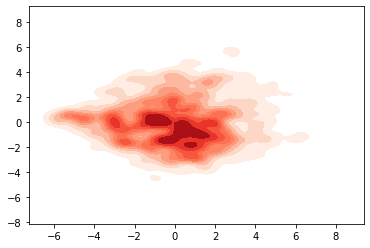

INFO:calc_z_likelihood:Built GM model with k = 1 and test aic = -1694643.4489001734
INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -1744025.56530858
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -1777471.939018659
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -1795668.812268858
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -1794980.3990124352
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -1790091.0449970157
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -1801977.5673390327
INFO:calc_z_likelihood:best gm model with k = 7 and test aic = -1801977.5673390327
INFO:Main:For label 0 log_p_gm_diag = 958338.7836695163
INFO:Main:For label 0 log_p_gaus_diag = 855513.7244500867
INFO:Main:For label 0 rel_diff =         0.12019101
INFO:Main:Training autoencoder for label 1


Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_2 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


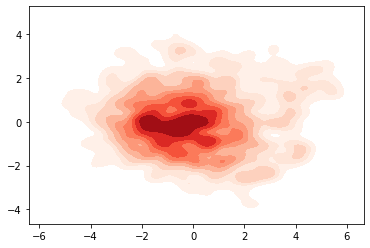

INFO:calc_z_likelihood:Built GM model with k = 1 and test aic = -1728054.4694562547
INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -1763261.844710957
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -1764880.6653577846
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -1762124.9632224112
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -1758110.3072044319
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -1745133.2617819465
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -1736813.1764122364
INFO:calc_z_likelihood:best gm model with k = 3 and test aic = -1764880.6653577846
INFO:Main:For label 1 log_p_gm_diag = 925756.5882061182
INFO:Main:For label 1 log_p_gaus_diag = 872219.2347281275
INFO:Main:For label 1 rel_diff =         0.06138062
INFO:Main:Training autoencoder for label 2


Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_3 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 2048)              8390656   
______________________________

INFO:Main:Apply PCA for 2D plot of Z
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


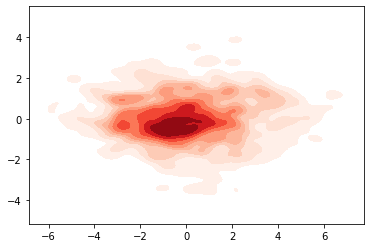

INFO:calc_z_likelihood:Built GM model with k = 1 and test aic = -1884575.9228765601
INFO:calc_z_likelihood:Built GM model with k = 2 and test aic = -1952601.0285346948
INFO:calc_z_likelihood:Built GM model with k = 3 and test aic = -1982609.4836865673
INFO:calc_z_likelihood:Built GM model with k = 4 and test aic = -1980164.1914091867
INFO:calc_z_likelihood:Built GM model with k = 5 and test aic = -1970027.5448144397
INFO:calc_z_likelihood:Built GM model with k = 6 and test aic = -1980756.5222908237
INFO:calc_z_likelihood:Built GM model with k = 7 and test aic = -1962249.035933773
INFO:calc_z_likelihood:best gm model with k = 3 and test aic = -1982609.4836865673
INFO:Main:For label 2 log_p_gm_diag = 1038474.5179668866
INFO:Main:For label 2 log_p_gaus_diag = 950479.9614382801
INFO:Main:For label 2 rel_diff =         0.09257908
INFO:Main:Training autoencoder for label 3


Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_4 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 4096)              12849152  
Total params: 12,868,544
Trainable params: 12,868,544
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 2048)              8390656   
______________________________

In [ ]:
# Main snippet for Z posterior estimation via boostrapping
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger('Main')
caes = dict()
train_labels2 = np.transpose(train_labels)[0]
test_labels2 = np.transpose(test_labels)[0]
labels_logps_dict = dict()
unique_labels = np.unique(train_labels)
for label in unique_labels:
    train_idx = train_labels2==label
    test_idx = test_labels2 == label
    
    train_images_label = train_images[train_idx,:,:]
    test_images_label = test_images[test_idx,:,:]

    logger.info(f'Training autoencoder for label {label}')
    caes[label]  = CAE(latent_dim)
    caes[label].compile(optimizer='adam', loss=losses.MeanSquaredError())
    caes[label].fit(train_images_label, train_images_label,
                epochs=10,
                shuffle=True,
                batch_size=batch_size,
                validation_data=(test_images_label, test_images_label))
    
    z = caes[label].encoder(test_images_label)
    if z.shape[0] >2:
        logger.info('Apply PCA for 2D plot of Z')
        s = StandardScaler()
        z_scaled = s.fit(z)
        pca = PCA(n_components=2)
        z_pca = pca.fit_transform(z)
        z1 = z_pca[:,0]
        z2 = z_pca[:,1]
    elif z.shape[0] == 2:
        z1 = z[:,0].numpy()
        z2 = z[:,1].numpy()
    else:
        raise ValueError('Z shape must be >=2')
    sns.kdeplot(pd.Series(z1), pd.Series(z2), cmap="Reds", shade=True, bw=.15)
    plt.show()
    
    logps = calc_z_likelihood(z=z)
    logger.info(f"""For label {label} log_p_gm_diag = {logps['GM_diag']}""")
    logger.info(f"""For label {label} log_p_gaus_diag = {logps['Gaus_diag']}""")
    diff = logps['GM_diag'] - logps['Gaus_diag']
    rel_diff = np.round(diff/np.abs(logps['Gaus_diag']),8)
    logger.info(f"""For label {label} rel_diff = \
        {rel_diff}""")
    
    entry = {'log_p_gm_diag':logps['GM_diag'],'log_p_gaus_diag':logps['Gaus_diag'],\
             'rel_diff': rel_diff }
    labels_logps_dict[label] = entry
    

In [ ]:
labels_logps_dict